In [2]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import quad_vec
import matplotlib.pyplot as plt
CurrentPath = os.getcwd()
sndata = pd.read_csv(CurrentPath + '/2025/parsonage.txt', sep = ' ', engine='python')

In [3]:
# observed data
mb = sndata['mb'].values
dmb = sndata['dmb'].values
z = sndata['zcmb'].values

In [4]:
dmb[3]

0.116

# 1. SN data

In [15]:
grid.shape

(100,)

## 1-1. Flat LCDM

In [100]:
from scipy.interpolate import interp1d

def E_inverse_flat(z, Omega_m): # return 1/E(z) = H0/H(z)
    Omega_L = 1 - Omega_m
    E = np.sqrt(Omega_m*(1+z)**3 + Omega_L)
    return 1/E


def Other_stuff_flat(z, parm): # parm[0] = Omegam, parm[1] = Omegalamb
    Omegam = parm[0]
    grid = np.linspace(z.min(), z.max(), 300)
    grid_dist = np.array([quad_vec(E_inverse_flat, 0,n, args=(Omegam))[0] for n in grid])
    interp_func = interp1d(grid, grid_dist, kind='linear', fill_value='extrapolate')
    integral = interp_func(z)
    
    return integral
def B(func, parm,z):
    """
    B(Omegam, Omegalamb) = 5*log10((1+z)*proper distance*H0/c)
    m(z) = A + B(Omegam, Omegalamb)
    input : 
        func : proper distance*H0/c (Other_stuff_flat or Other_stuff_curved)
        parm : [Omegam, Omegalamb] 
        z : redshift
    output :
        Bval : B(Omegam, Omegalamb)
    """
    Bval = 5*np.log10((1+z)*func(z, parm))
    return Bval

def A(func,mb, dmb,z, parm):
    ndata = mb.size
    A = 1/ndata*np.sum(dmb**2)*np.sum((mb - B(func,parm,z))/(dmb**2))
    return A

from tqdm import tqdm

# 1. make a code that accounts for a prior
def ln_prior(min,max):
    volume = np.prod(np.abs(min - max)) # volume of the prior
    return np.log(1/volume)

def Loglikelihood(func, parm,SNdata): # return Loglikelihood = -chisq, parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb
    mb = SNdata['mb'].values
    dmb = SNdata['dmb'].values
    z = SNdata['zcmb'].values
    m_z = A(func, mb,dmb, z, parm) + B(func, parm, z) # m_z = A + B(Omegam, Omegalamb)
    diff = (mb - m_z)**2
    chisq = np.sum(diff/dmb**2)
    return -chisq

def ln_f(func, parm,SNdata, prior, lnprior): # return total Loglikelihood
    bool = np.all((prior[0] <= parm) & (parm <= prior[1]))
    if bool == True:
        return lnprior + Loglikelihood(func, parm, SNdata) # param[0] = H0, param[1] = Omegam, param[2] = Omegalamb
    else:
        return -np.inf

def Markov(func, paramk,paramkp1,SNdata, prior, lnprior):
    minuschisqk = ln_f(func, paramk, SNdata, prior, lnprior)
    minuschisqkp1 = ln_f(func, paramkp1, SNdata, prior, lnprior)
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk

def MCMC(func, paraminit,SNdata, nstep,normal_vec,prior): # param0 = [H0, Omegam, Omegalamb]
    lnprior = ln_prior(prior[0], prior[1]) # calculate the prior volume likelihood
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    stepsize = normal_vec
    for k in tqdm(range(nstep)):
        paramkp1 = np.array(param0 + np.random.normal(0,stepsize))
        param0, loglikelihood = Markov(func, param0, paramkp1,SNdata, prior, lnprior) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

In [97]:
Prior1 = np.array([[0.],[1.]])

In [102]:
normal_vec = np.array([0.00001])*0.05
std = np.array([7.207595017419446e-06])
paraminit = np.array([1.8121254406749585e-05]) + np.random.normal(0,std)
nstep = int(2e3)
MCMC_test = MCMC(Other_stuff_flat, paraminit, sndata, nstep, normal_vec, Prior1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:47<00:00, 11.91it/s]


accept_ratio = 0.0033333333333333335
Best_fit = Omega_m : 9.873879441069234e-10
std = 2.2682419669960102e-10


(array([1.797e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([9.87387944e-10, 1.17969840e-09, 1.37200886e-09, 1.56431932e-09,
        1.75662978e-09, 1.94894024e-09, 2.14125070e-09, 2.33356116e-09,
        2.52587162e-09, 2.71818208e-09, 2.91049254e-09, 3.10280300e-09,
        3.29511346e-09, 3.48742392e-09, 3.67973438e-09, 3.87204483e-09,
        4.06435529e-09, 4.25666575e-09, 4.44897621e-09, 4.64128667e-09,
        4.833597

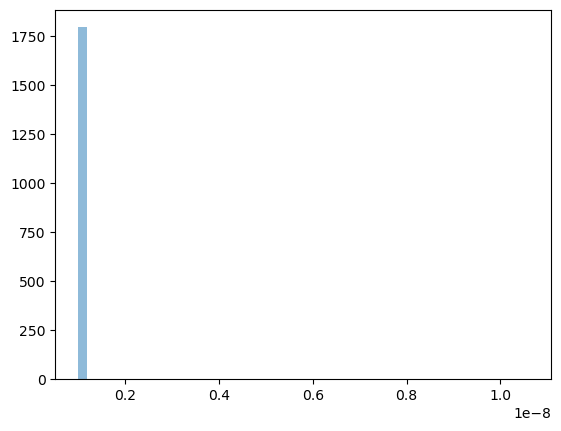

In [103]:

MCMC_test = MCMC_test[:,200:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-200)

Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0])
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}')
print(f'std = {std}')
plt.hist(MCMC_test[0],bins=50,alpha=0.5, label='Omega_m')

In [98]:
# test
def Other_stuff_test(z, parm): # parm[0] = Omegam, parm[1] = Omegalamb
    Omegam = parm[0]
    grid_dist = np.array([quad_vec(E_inverse_flat, 0,n, args=(Omegam))[0] for n in z])
    return grid_dist
def Loglikelihood(func, parm,SNdata): # return Loglikelihood = -chisq, parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb
    mb = SNdata['mb'].values
    dmb = SNdata['dmb'].values
    z = SNdata['zcmb'].values
    m_z = A(func, mb,dmb, z, parm) + B(func,parm, z) # m_z = A + integral
    diff = (mb - m_z)**2
    chisq = np.sum(diff/dmb**2)
    return -chisq

In [101]:
parm = np.array([0.1])
Error = np.abs(Other_stuff_flat(z, parm) - Other_stuff_test(z, parm)).mean()
Error2 = np.abs(B(Other_stuff_flat, parm, z) - B(Other_stuff_test, parm, z)).mean()
Error3 = np.abs(A(Other_stuff_flat, mb, dmb, z, parm) - A(Other_stuff_test, mb, dmb, z, parm)).mean()
print(f'Error = {Error}, Error2 = {Error2}, Error3 = {Error3}')


Error = 7.258364581630221e-07, Error2 = 1.785897351411649e-05, Error3 = 0.02222413765048259


## 1-2. Curved LCDM

In [132]:
from scipy.interpolate import interp1d

def E_inverse_curved(z, Omega_m, Omegalamb): # return 1/E(z) = H0/H(z)
    Omega_k = 1 - Omega_m-Omegalamb
    E = np.sqrt(Omega_m*(1+z)**3 + Omegalamb + Omega_k*(1+z)**2)
    return 1/E


def Other_stuff_curved(z, parm): # parm[0] = Omegam, parm[1] = Omegalamb
    Omegam = parm[0]
    Omegalamb = parm[1]
    grid = np.linspace(z.min(), z.max(), 100)
    grid_dist = np.array([quad_vec(E_inverse_curved, 0,n, args=(Omegam, Omegalamb))[0] for n in grid])
    interp_func = interp1d(grid, grid_dist, kind='linear', fill_value='extrapolate')
    integral = interp_func(z)
    
    return integral
def B(func, parm,z):
    """
    B(Omegam, Omegalamb) = 5*log10((1+z)*proper distance*H0/c)
    m(z) = A + B(Omegam, Omegalamb)
    input : 
        func : proper distance*H0/c (Other_stuff_flat or Other_stuff_curved)
        parm : [Omegam, Omegalamb] 
        z : redshift
    output :
        Bval : B(Omegam, Omegalamb)
    """
    Bval = 5*np.log10((1+z)*func(z, parm))
    return Bval

def A(func,mb, dmb,z, parm):
    ndata = mb.size
    A = 1/ndata*np.sum(dmb**2)*np.sum((mb - B(func,parm,z))/(dmb**2))
    return A

from tqdm import tqdm

# 1. make a code that accounts for a prior
def ln_prior(min,max):
    volume = np.prod(np.abs(min - max)) # volume of the prior
    return np.log(1/volume)

def Loglikelihood(func, parm,SNdata): # return Loglikelihood = -chisq, parm[0] = H0, parm[1] = Omegam, parm[2] = Omegalamb
    mb = SNdata['mb'].values
    dmb = SNdata['dmb'].values
    z = SNdata['zcmb'].values
    m_z = A(func, mb,dmb, z, parm) + B(func, parm, z) # m_z = A + B(Omegam, Omegalamb)
    diff = (mb - m_z)**2
    chisq = np.sum(diff/dmb**2)
    return -chisq

def ln_f(func, parm,SNdata, prior, lnprior): # return total Loglikelihood
    bool = np.all((prior[0] <= parm) & (parm <= prior[1]))
    if bool == True:
        return lnprior + Loglikelihood(func, parm, SNdata) # param[0] = H0, param[1] = Omegam, param[2] = Omegalamb
    else:
        return -np.inf

def Markov(func, paramk,paramkp1,SNdata, prior, lnprior):
    minuschisqk = ln_f(func, paramk, SNdata, prior, lnprior)
    minuschisqkp1 = ln_f(func, paramkp1, SNdata, prior, lnprior)
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk

def MCMC(func, paraminit,SNdata, nstep,normal_vec,prior): # param0 = [H0, Omegam, Omegalamb]
    lnprior = ln_prior(prior[0], prior[1]) # calculate the prior volume likelihood
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    stepsize = normal_vec
    for k in tqdm(range(nstep)):
        paramkp1 = np.array(param0 + np.random.normal(0,stepsize))
        param0, loglikelihood = Markov(func, param0, paramkp1,SNdata, prior, lnprior) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

In [135]:
Prior2 = np.array([[0., 0.],[2.5, 2.5]])
normal_vec = np.array([0.05402054,0.17674167])*0.0000001
std = np.array([0.0,0.0])
paraminit = np.array([0.023407863506195, 1.7285594052611333]) + np.random.normal(0,std)
nstep = int(2e3)
MCMC_test = MCMC(Other_stuff_curved, paraminit, sndata, nstep, normal_vec, Prior2)

  0%|                                                                                                                                                                       | 0/2000 [00:00<?, ?it/s]/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_2701/3330054488.py:5: RuntimeWarning: invalid value encountered in sqrt
  E = np.sqrt(Omega_m*(1+z)**3 + Omegalamb + Omega_k*(1+z)**2)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:33<00:00, 21.45it/s]


accept_ratio = 0.0016666666666666668
Best_fit = Omega_m : 0.023407863506195, Omegalamb : 1.7285594052611333
std = [3.46944695e-18 2.22044605e-16]


Text(0.5, 1.0, 'MCMC result for Flat LCDM')

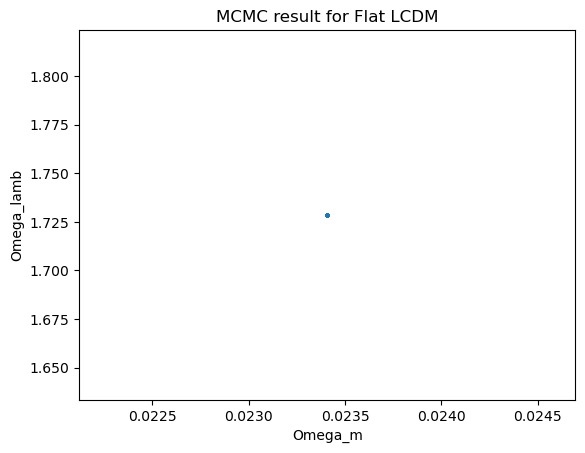

In [136]:
MCMC_test = MCMC_test[:,200:]
accept_ratio = np.unique(MCMC_test).shape[0] / (nstep-200)
Best_fit = MCMC_test[:,np.argmax(MCMC_test[-1])]
std = np.std(MCMC_test[0:2], axis=1)
print(f'accept_ratio = {accept_ratio}')
print(f'Best_fit = Omega_m : {Best_fit[0]}, Omegalamb : {Best_fit[1]}')
print(f'std = {std}')
plt.scatter(MCMC_test[0], MCMC_test[1], s=2, alpha=0.5)
plt.xlabel('Omega_m')
plt.ylabel('Omega_lamb')
plt.title('MCMC result for Flat LCDM')